In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [ ]:
# ==================================================
# STEP 1: Setup Kaggle API (Run this ONCE)
# ==================================================
# You'll need a Kaggle account and API token
# 1. Go to: https://www.kaggle.com/settings/account
# 2. Click "Create New API Token" - downloads kaggle.json
# 3. Upload kaggle.json to Colab using the file upload below

from google.colab import files
import os

print("Upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✓ Kaggle API configured successfully!")

Upload your kaggle.json file:


Saving kaggle.json to kaggle (2).json
✓ Kaggle API configured successfully!


In [ ]:
# ==================================================
# STEP 2: Download Dataset from Kaggle
# ==================================================
# Downloads lung and colon cancer histopathological images
# Size: ~1.2 GB | Time: 2-5 minutes depending on connection

!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

print("✓ Dataset downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)
✓ Dataset downloaded successfully!


In [ ]:
# ==================================================
# STEP 3: Extract and Organize Dataset
# ==================================================
import zipfile
import shutil

# Extract the downloaded zip file
print("Extracting dataset...")
with zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('lung_colon_data')

print("✓ Extraction complete!")

# Organize into train/test folders
print("\nOrganizing dataset structure...")

# Create directory structure in Google Drive
!mkdir -p "/content/drive/MyDrive/Lung_Cancer_Dataset/train"
!mkdir -p "/content/drive/MyDrive/Lung_Cancer_Dataset/test"

# Move lung cancer classes only (we'll skip colon cancer classes)
lung_classes = ['lung_aca', 'lung_n', 'lung_scc']

for class_name in lung_classes:
    # Find the class folder in extracted data
    source_path = f"lung_colon_data/lung_colon_image_set/lung_image_sets/{class_name}"

    if os.path.exists(source_path):
        images = os.listdir(source_path)
        total = len(images)
        train_split = int(0.8 * total)  # 80% train, 20% test

        # Create class folders
        train_class_dir = f"/content/drive/MyDrive/Lung_Cancer_Dataset/train/{class_name}"
        test_class_dir = f"/content/drive/MyDrive/Lung_Cancer_Dataset/test/{class_name}"
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Copy training images
        for img in images[:train_split]:
            shutil.copy(
                f"{source_path}/{img}",
                f"{train_class_dir}/{img}"
            )

        # Copy testing images
        for img in images[train_split:]:
            shutil.copy(
                f"{source_path}/{img}",
                f"{test_class_dir}/{img}"
            )

        print(f"✓ {class_name}: {train_split} train, {total - train_split} test images")
 #lung_aca: Adenocarcinoma
 #lung_n : normal tissue
 #lung_scc:squamous cell carcinoma
print("\n" + "="*50)
print("DATASET SETUP COMPLETE!")
print("="*50)
print("Location: /content/drive/MyDrive/Lung_Cancer_Dataset/")
print("\nStructure:")
print("  train/")
print("    ├── lung_aca/    (adenocarcinoma)")
print("    ├── lung_n/      (normal tissue)")
print("    └── lung_scc/    (squamous cell carcinoma)")
print("  test/")
print("    ├── lung_aca/")
print("    ├── lung_n/")
print("    └── lung_scc/")

Extracting dataset...
✓ Extraction complete!

Organizing dataset structure...
✓ lung_aca: 4000 train, 1000 test images
✓ lung_n: 4000 train, 1000 test images
✓ lung_scc: 4000 train, 1000 test images

DATASET SETUP COMPLETE!
Location: /content/drive/MyDrive/Lung_Cancer_Dataset/

Structure:
  train/
    ├── lung_aca/    (adenocarcinoma)
    ├── lung_n/      (normal tissue)
    └── lung_scc/    (squamous cell carcinoma)
  test/
    ├── lung_aca/
    ├── lung_n/
    └── lung_scc/


## **Understanding the Images: Histopathology 101**

### **🔬 How These Images Are Taken**

**The Process:**
1. **Tissue Collection**: Lung tissue sample obtained during biopsy or surgery
2. **Fixation**: Tissue preserved in formalin to prevent decay
3. **Embedding**: Tissue embedded in paraffin wax for stability
4. **Sectioning**: Ultra-thin slices cut (3-5 micrometers thick - thinner than human hair!)
5. **Mounting**: Slices placed on glass slides
6. **Staining**: H&E (Hematoxylin & Eosin) stain applied:
   - **Hematoxylin (blue/purple)**: Stains cell nuclei (DNA)
   - **Eosin (pink/red)**: Stains cytoplasm and extracellular proteins
7. **Imaging**: Photographed through microscope at 40x magnification (400x zoom)
8. **Digitization**: Images captured at 768×768 pixels

**What You're Seeing**: Each image shows cellular detail invisible to the naked eye - approximately **0.5mm × 0.5mm** of tissue magnified 400 times!

---

### **🎨 Visual Guide: How to Spot Cancer**

#### **NORMAL TISSUE (`lung_n`) - The Healthy Baseline**
```
Visual Characteristics:
✅ ORGANIZED STRUCTURE
   - Clear "bubble-like" air spaces (alveoli)
   - Uniform, regular spacing
   - Thin, delicate walls

✅ COLOR PATTERN
   - Light pink background (healthy tissue)
   - Small purple dots (normal cell nuclei)
   - Lots of white/empty space (air pockets)

✅ CELL ARRANGEMENT
   - Cells line up neatly along alveolar walls
   - Consistent cell sizes
   - "Honeycomb" or "bubble wrap" appearance

🔍 LOOK FOR: Organized, airy, spacious, uniform
```

---

#### **ADENOCARCINOMA (`lung_aca`) - The Gland-Former**
```
Visual Characteristics:
❌ DISORGANIZED GROWTH
   - Loss of normal air space structure
   - Cells form irregular glands/circles
   - Crowded, chaotic appearance

❌ COLOR PATTERN
   - DARK PURPLE areas (many cell nuclei packed together)
   - Dense clustering of cells
   - Loss of pink, airy background

❌ ABNORMAL PATTERNS
   - Glandular formations (irregular circles/ovals)
   - "Nests" or "clusters" of cancer cells
   - Abnormally large, dark nuclei
   - Cells trying to form tube-like structures

🔍 LOOK FOR: Dark purple clusters, circular gland patterns, crowded cells
🔬 KEY MARKER: Glandular/circular formations with dense nuclei
```

**Why It Happens**: These cancer cells are trying to form glands (mucus-producing structures), but they do it abnormally and uncontrollably.

---

#### **SQUAMOUS CELL CARCINOMA (`lung_scc`) - The Sheet-Former**
```
Visual Characteristics:
❌ LAYERED/SHEET GROWTH
   - Cells grow in sheets or layers
   - Stratified appearance (like layered cake)
   - Very dense cellular packing

❌ COLOR PATTERN
   - BRIGHT PINK areas (keratin production)
   - Swirled, "whorled" patterns
   - Very dark purple nuclei (abnormal, large)

❌ DISTINCTIVE FEATURES
   - "Squamous pearls" (concentric circles of cells)
   - Keratin deposits (bright pink swirls)
   - Necrotic centers (pale/dead tissue in middle)
   - Intercellular bridges visible

🔍 LOOK FOR: Bright pink keratin, layered sheets, swirled patterns
🔬 KEY MARKER: Keratin pearls (pink concentric circles) and sheet-like growth
```

**Why It Happens**: These cells are trying to produce keratin (normally found in skin), which shouldn't happen in lung tissue. The bright pink is the keratin protein.

---

### **🚨 Cancer Visual Red Flags**

When comparing images, cancer shows:

| Feature | Normal | Cancer (Both Types) |
|---------|--------|---------------------|
| **Density** | Sparse, airy | Packed, crowded |
| **Organization** | Uniform pattern | Chaotic, irregular |
| **Nuclei** | Small, uniform | Large, dark, varied sizes |
| **Color** | Light pink, open | Dark purple (aca) or bright pink (scc) |
| **Space** | Lots of white space | Little to no white space |
| **Pattern** | Honeycomb structure | Lost architecture |

---

### **💡 Pro Tips for Visual Analysis**

1. **Zoom In**: Look at individual cell shapes and sizes
2. **Check Spacing**: Cancer = crowded, Normal = organized gaps
3. **Find Purple**: More dark purple = more cell nuclei = more cells = possible cancer
4. **Look for Pink Swirls**: Bright pink keratin = squamous cell carcinoma marker
5. **Seek Circles**: Glandular circular patterns = adenocarcinoma marker
6. **Compare**: Always compare to normal tissue to see the difference

---

### **🤖 What The AI Learns**

The CNN model extracts these visual patterns automatically:
- **Color histograms**: Distribution of purple vs pink
- **Texture features**: Smooth vs rough patterns
- **Spatial patterns**: Organized vs chaotic arrangements
- **Edge detection**: Cell boundaries and shapes
- **Density maps**: How crowded cells are

**The Model Essentially Becomes a Digital Pathologist** - but can analyze thousands of images per second!

---

**Run the visualization above to see real examples of each class and practice identifying these patterns!** 👆

In [ ]:
# ==================================================
# ENGINEERING DECISION: Dataset Organization
# ==================================================
# Dataset: Lung and Colon Cancer Histopathological Images (25,000 images)
# Structure: Training and Testing folders with class subfolders
# Classes: lung_aca (adenocarcinoma), lung_scc (squamous cell carcinoma), lung_n (benign)
# Image Size: 768x768 pixels (will be resized to 224x224 for VGG16)
# WHY: Histopathological images provide cellular-level detail for accurate cancer detection
# ==================================================

train_dir = '/content/drive/MyDrive/Lung_Cancer_Dataset/train/'
test_dir = '/content/drive/MyDrive/Lung_Cancer_Dataset/test/'

# ==================================================
# ENGINEERING STEP 1: Data Collection and Organization
# ==================================================
# WHY SHUFFLE?: Prevents model from learning based on data order
# - Neural networks can memorize patterns in sequential data
# - Shuffling ensures random distribution across batches
# - Critical for unbiased gradient descent optimization
# ==================================================

# Load and shuffle the train data
train_paths = []  # Store file paths for lazy loading (memory efficient)
train_labels = []  # Store string labels (will be encoded to integers later)

for label in os.listdir(train_dir):  # Iterate through class folders
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)  # Keep as string for now

# Shuffle to randomize data order (prevents sequential bias)
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

print(f"Training samples loaded: {len(train_paths)}")
print(f"Classes found: {set(train_labels)}")

# Load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

print(f"Testing samples loaded: {len(test_paths)}")

Training samples loaded: 12000
Classes found: {'lung_scc', 'lung_n', 'lung_aca'}
Testing samples loaded: 3000


# Data Visualization

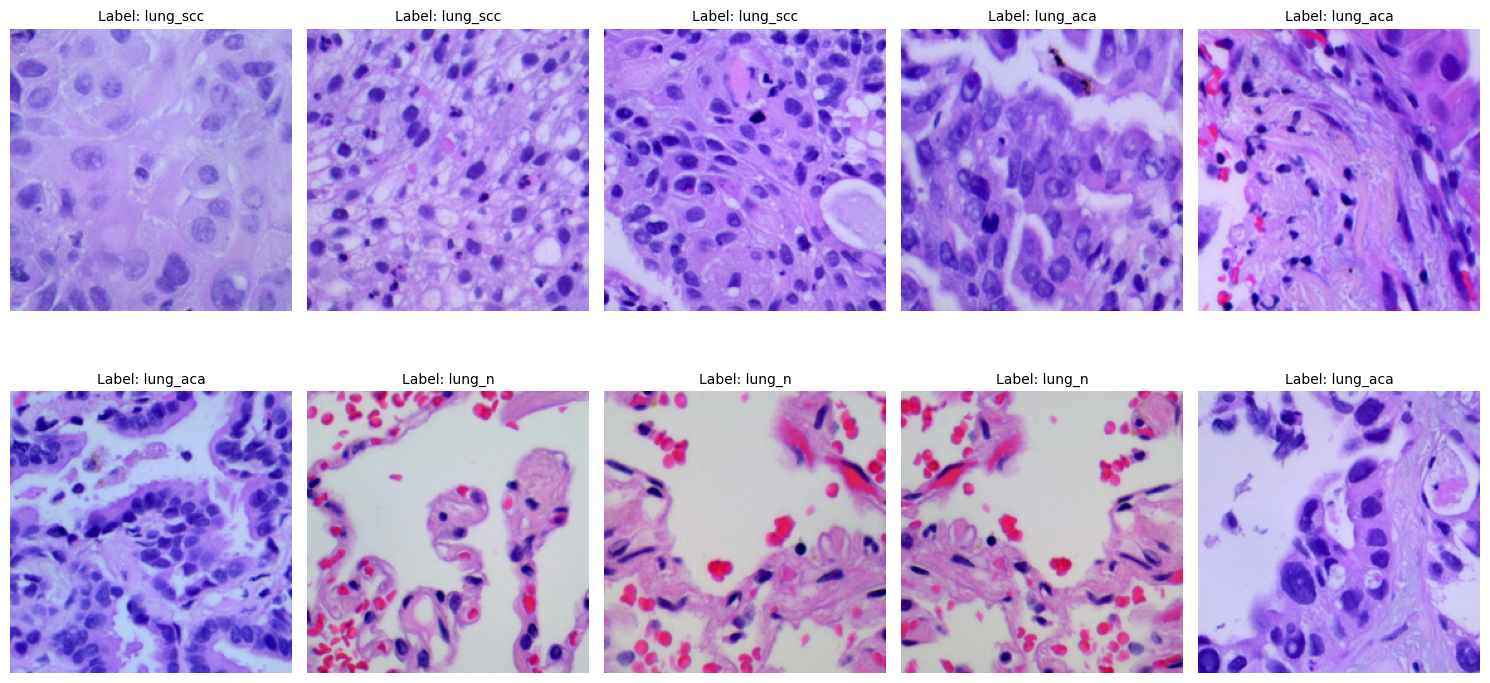

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# ==================================================
# ENGINEERING STEP 2: Data Augmentation Pipeline
# ==================================================
# WHY AUGMENTATION?: Increases dataset diversity to prevent overfitting
# - Medical datasets are often small (expensive to collect and label)
# - Augmentation creates variations without collecting new data
# - Simulates real-world variations (lighting, staining differences)
# ==================================================

def augment_image(image):
    """
    Apply random augmentation to a single image.

    ENGINEERING RATIONALE:
    - Brightness: Simulates different microscope lighting conditions (0.8-1.2x)
    - Contrast: Simulates different staining intensities in histopathology
    - Normalization: Scales pixel values to [0,1] for stable gradient flow

    WHY NORMALIZE?: Neural networks train better with inputs in small ranges
    - Prevents exploding/vanishing gradients
    - Ensures all features contribute equally initially
    - Standard practice for image-based deep learning
    """
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def open_images(paths):
    """
    Load and preprocess multiple images.

    ENGINEERING DECISION: Resize to IMAGE_SIZE x IMAGE_SIZE
    - VGG16 expects consistent input dimensions
    - Resizing ensures all images have same shape
    - Trade-off: Loss of detail vs. computational efficiency
    """
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

def encode_label(labels):
    """
    Convert string labels to integer encodings.

    WHY?: Neural networks need numerical inputs
    - Converts ['lung_aca', 'lung_n', 'lung_scc'] to [0, 1, 2]
    - Maintains consistent mapping throughout training
    - Required for sparse_categorical_crossentropy loss
    """
    unique_labels = sorted(os.listdir(train_dir))  # Sort for consistency
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def datagen(paths, labels, batch_size=12):
    """
    Generator function for memory-efficient batch processing.

    WHY USE GENERATOR?: Memory optimization for large datasets
    - Loads only one batch at a time (not entire dataset)
    - Critical for limited RAM environments (Google Colab)
    - Prevents out-of-memory errors

    HOW IT WORKS:
    1. Loops infinitely (while True)
    2. Yields batches one at a time
    3. model.fit() controls when to stop via epochs parameter
    4. Images are loaded on-demand, then discarded

    WHY INFINITE LOOP?: Generator must produce data for all epochs
    - Keras will call this generator repeatedly
    - Must not exhaust after first epoch
    """
    while True:  # Infinite loop - Keras controls stopping
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [ ]:
# ==================================================
# ENGINEERING STEP 3: Model Architecture Design
# ==================================================
# TRANSFER LEARNING STRATEGY: VGG16 Pre-trained on ImageNet
# WHY VGG16?:
# 1. Pre-trained on 14M images - learned universal visual features
# 2. Deep architecture (16 layers) - captures complex patterns
# 3. Proven effectiveness for medical imaging
# 4. Reduces training time from weeks to hours
# ==================================================

IMAGE_SIZE = 224  # VGG16 optimal input size (224x224x3)
# WHY 224?: VGG16 was originally trained on 224x224 ImageNet images
# Using same size preserves learned feature representations

base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),  # RGB images
    include_top=False,  # Remove original classification head (1000 ImageNet classes)
    weights='imagenet'  # Load pre-trained weights
)

# ==================================================
# PROGRESSIVE UNFREEZING STRATEGY: Staged Fine-Tuning
# ==================================================
# WHY PROGRESSIVE UNFREEZING?:
# - Prevents random gradients from untrained head destroying pre-trained weights
# - Epochs 1-2: Train only classification head (all VGG16 frozen)
# - Epoch 3+: Unfreeze last 3 VGG16 layers for task-specific fine-tuning
# ==================================================

# Freeze ALL layers initially (including last layers)
for layer in base_model.layers:
    layer.trainable = False

print("Initial VGG16 State (All Frozen):")
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

print("\n" + "="*50)
print("STAGE 1 (Epochs 1-2): Training classification head only")
print("STAGE 2 (Epoch 3+): Unfreezing last 3 VGG16 layers")
print("="*50)

# ==================================================
# CUSTOM CLASSIFICATION HEAD
# ==================================================

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)

# Flatten: Converts 3D feature maps to 1D vector
# Output shape: (None, 7*7*512) = (None, 25088) for VGG16
model.add(Flatten())

# Dropout: Stronger regularization to prevent overfitting
# WHY 0.5?: Drops 50% of neurons - aggressive regularization
# - Prevents co-adaptation of neurons
# - Forces model to learn robust features
# - Critical for preventing overfitting on medical datasets
model.add(Dropout(0.5))

# Dense: Fully connected layer
# WHY 128 neurons?: Balance between capacity and overfitting
# - Enough to learn complex decision boundaries
# - Not so large that it memorizes training data
model.add(Dense(128, activation='relu'))

# Second dropout layer (moderate regularization)
model.add(Dropout(0.3))

# Output layer: Number of neurons = number of classes
# WHY SOFTMAX?: Converts logits to probability distribution
# - Outputs sum to 1.0
# - Interpretable as class probabilities
num_classes = len(os.listdir(train_dir))
model.add(Dense(num_classes, activation='softmax'))

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {sorted(os.listdir(train_dir))}")

model.summary()

# ==================================================
# MODEL COMPILATION: Loss, Optimizer, Metrics
# ==================================================
# WHY ADAM OPTIMIZER?
# - Industry standard for computer vision
# - Handles sparse gradients well
# - Adaptive learning rates per parameter

# WHY LOW LEARNING RATE (0.0001)?
# - Pre-trained weights are already good
# - Fine-tuning requires gentle updates
# - Large LR would destroy learned features


# ==================================================
# TRAINING CONFIGURATION WITH VALIDATION SPLIT
# ==================================================
# WHY VALIDATION?: Monitor generalization during training
# - Detects overfitting early (train accuracy high, val accuracy low)
# - Enables early stopping to prevent wasted computation
# - Provides real-time feedback on model performance
# ==================================================

batch_size = 16
total_epochs = 5
unfreeze_epoch = 3 # Unfreeze at the beginning of this epoch

# Split training data: 80% train, 20% validation
val_split_idx = int(0.8 * len(train_paths))
train_paths_only = train_paths[:val_split_idx]
train_labels_only = train_labels[:val_split_idx]
val_paths = train_paths[val_split_idx:]
val_labels = train_labels[val_split_idx:]

train_steps = int(len(train_paths_only) / batch_size)
val_steps = int(len(val_paths) / batch_size)

print(f"\nTraining Configuration:")
print(f"Total samples: {len(train_paths)}")
print(f"  - Training samples: {len(train_paths_only)}")
print(f"  - Validation samples: {len(val_paths)}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch:")
print(f"  - Training steps: {train_steps}")
print(f"  - Validation steps: {val_steps}")
print(f"Total epochs: {total_epochs}")
print(f"Total training steps: {train_steps * total_epochs}")

# ==================================================
# CALLBACKS: Early Stopping
# ==================================================
# WHY EARLY STOPPING?
# - Stops training when validation loss stops improving
# - Prevents wasting computation on overfitting
# - Automatically saves best model weights
# - Patience=3: Allow 3 epochs of no improvement before stopping
# ==================================================
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',           # Watch validation loss
    patience=3,                   # Stop if no improvement for 3 epochs
    restore_best_weights=True,    # Revert to best weights
    verbose=1                     # Print when stopping
)

# ==================================================
# STAGED TRAINING (Fix for TypeError: 'NoneType' object is not callable)
# ==================================================
# Stage 1: Train only the classification head (VGG16 frozen)
print("\n" + "="*50)
print(f"STARTING STAGE 1 TRAINING (Epochs 1-{unfreeze_epoch-1}): Classification head only")
print("="*50)

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Conservative LR
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_stage1 = model.fit(
    datagen(train_paths_only, train_labels_only, batch_size=batch_size),
    steps_per_epoch=train_steps,
    validation_data=datagen(val_paths, val_labels, batch_size=batch_size),
    validation_steps=val_steps,
    epochs=unfreeze_epoch - 1, # Train for initial epochs
    callbacks=[early_stop] # Use early stopping
)

print("\n" + "="*50)
print(f"STAGE 1 TRAINING COMPLETED. Current Epoch: {history_stage1.epoch[-1] + 1 if history_stage1.epoch else 0}")
print("="*50)

# Stage 2: Unfreeze VGG16 layers and fine-tune
print("\n" + "="*50)
print(f"STARTING STAGE 2 TRAINING (Epochs {unfreeze_epoch}-{total_epochs}): Fine-tuning last 3 VGG16 layers")
print("Unfreezing layers: block5_conv1, block5_conv2, block5_conv3")
print("="*50)

# Unfreeze last 3 convolutional layers
base_model.layers[-2].trainable = True  # Block5 Conv3
base_model.layers[-3].trainable = True  # Block5 Conv2
base_model.layers[-4].trainable = True  # Block5 Conv1

# Recompile model with unfrozen layers (with potentially lower LR for fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Even lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_stage2 = model.fit(
    datagen(train_paths_only, train_labels_only, batch_size=batch_size),
    steps_per_epoch=train_steps,
    validation_data=datagen(val_paths, val_labels, batch_size=batch_size),
    validation_steps=val_steps,
    epochs=total_epochs, # Train up to total_epochs
    initial_epoch=history_stage1.epoch[-1] + 1 if history_stage1.epoch else 0, # Start from where previous training left off
    callbacks=[early_stop] # Use early stopping
)

print("\n" + "="*50)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
# Save the entire model
model.save('model.h5')
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')


Initial VGG16 State (All Frozen):
Layer 0: input_layer - Trainable: False
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: False
Layer 9: block3_conv3 - Trainable: False
Layer 10: block3_pool - Trainable: False
Layer 11: block4_conv1 - Trainable: False
Layer 12: block4_conv2 - Trainable: False
Layer 13: block4_conv3 - Trainable: False
Layer 14: block4_pool - Trainable: False
Layer 15: block5_conv1 - Trainable: False
Layer 16: block5_conv2 - Trainable: False
Layer 17: block5_conv3 - Trainable: False
Layer 18: block5_pool - Trainable: False

STAGE 1 (Epochs 1-2): Training classification head only
STAGE 2 (Epoch 3+): Unfreezing last 3 VGG16 layers

Number of classes: 3
Classes: ['lung_aca', 'lung_n', 'lung_scc']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training Configuration:
Total samples: 12000
  - Training samples: 9600
  - Validation samples: 2400
Batch size: 16
Steps per epoch:
  - Training steps: 600
  - Validation steps: 150
Total epochs: 5
Total training steps: 3000

STARTING STAGE 1 TRAINING (Epochs 1-2): Classification head only
Epoch 1/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 170s 265ms/step - loss: 0.4437 - sparse_categorical_accuracy: 0.8113 - val_loss: 0.1301 - val_sparse_categorical_accuracy: 0.9475
Epoch 2/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 140s 234ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.1063 - val_sparse_categorical_accuracy: 0.9571
Restoring model weights from the end of the best epoch: 2.

STAGE 1 TRAINING COMPLETED. Current Epoch: 2

STARTING STAGE 2 TRAINING (Epochs 3-5): Fine-tuning last 3 VGG16 layers
Unfreezing layers: block5_conv1, block5_conv2, block5_conv3
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 130s 207ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.1102 - va


TRAINING COMPLETED SUCCESSFULLY!


# Train and Val Plots

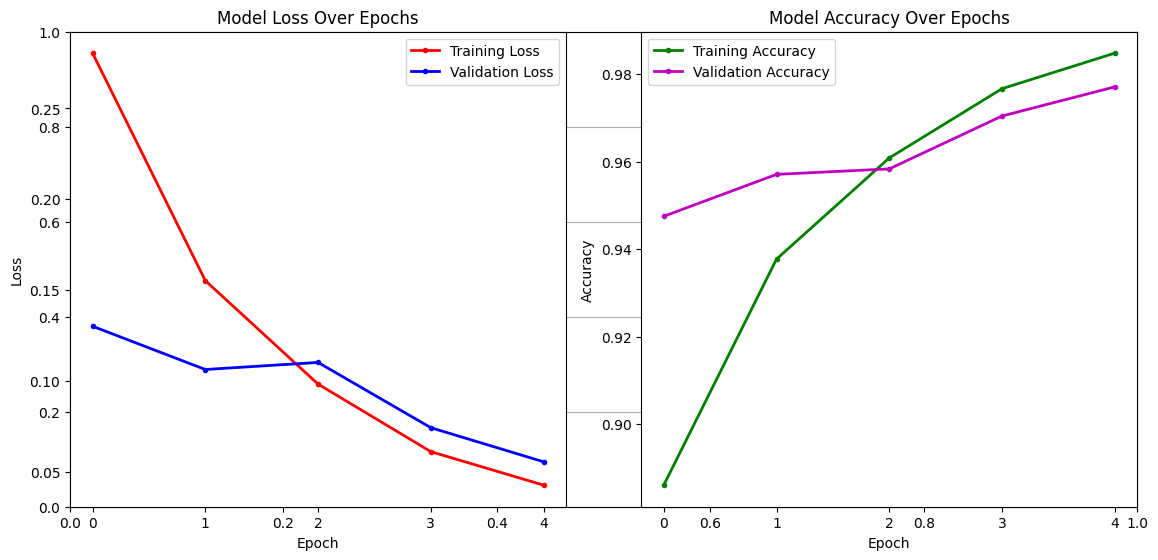

In [ ]:
import matplotlib.pyplot as plt

# Combine the histories from both training stages
history = {}
for key in history_stage1.history.keys():
    history[key] = history_stage1.history[key] + history_stage2.history[key]

# Check if early stopping truncated the total_epochs
actual_epochs_run = len(history['loss'])

plt.figure(figsize=(12, 6))
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history['loss'], '.r-', linewidth=2, label='Training Loss')
plt.plot(history['val_loss'], '.b-', linewidth=2, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(actual_epochs_run))
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history['sparse_categorical_accuracy'], '.g-', linewidth=2, label='Training Accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], '.m-', linewidth=2, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(actual_epochs_run))
plt.legend()

plt.tight_layout()
plt.show()


# Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.95      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



# Model Confusion Plot

Confusion Matrix:
[[992   0   8]
 [  2 998   0]
 [ 45   0 955]]


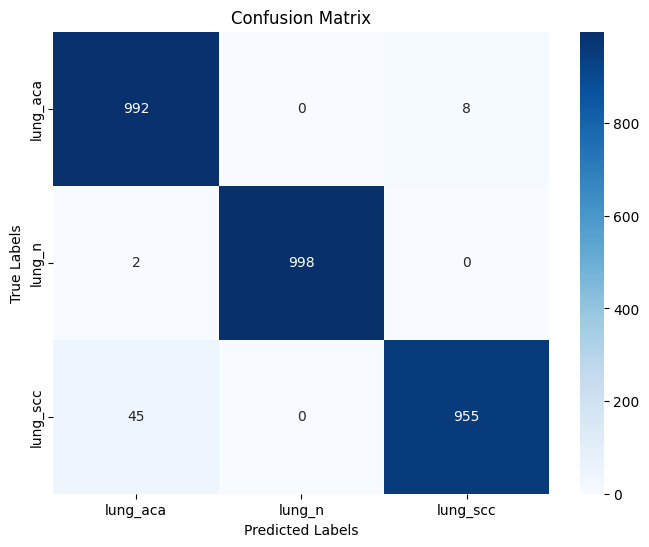

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

# ==================================================
# INFERENCE SYSTEM: Lung Cancer Detection
# ==================================================

class_labels = sorted(os.listdir(train_dir))

class_names_full = {
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Normal Tissue',
    'lung_scc': 'Squamous Cell Carcinoma'
}

def detect_and_display(img_path, model, image_size=224):
    """
    Detect lung cancer from histopathological image.
    """
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)

        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        predicted_label = class_labels[predicted_class_index]
        full_name = class_names_full.get(predicted_label, predicted_label)

        if predicted_label == 'lung_n':
            result = "Normal Tissue (No Cancer Detected)"
            color = 'green'
        else:
            result = f"Cancer Detected: {full_name}"
            color = 'red'

        if confidence_score >= 0.9:
            confidence_level = "High"
        elif confidence_score >= 0.7:
            confidence_level = "Medium"
        else:
            confidence_level = "Low - Manual Review Recommended"

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"{result}\nConfidence: {confidence_score * 100:.2f}% ({confidence_level})",
            fontsize=14,
            color=color,
            weight='bold'
        )
        plt.show()

        print("\nDetailed Prediction Probabilities:")
        print("=" * 50)
        for i, label in enumerate(class_labels):
            prob = predictions[0][i] * 100
            print(f"{class_names_full.get(label, label)}: {prob:.2f}%")

    except Exception as e:
        print("Error processing the image:", str(e))



Testing Image 1: Adenocarcinoma Sample
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


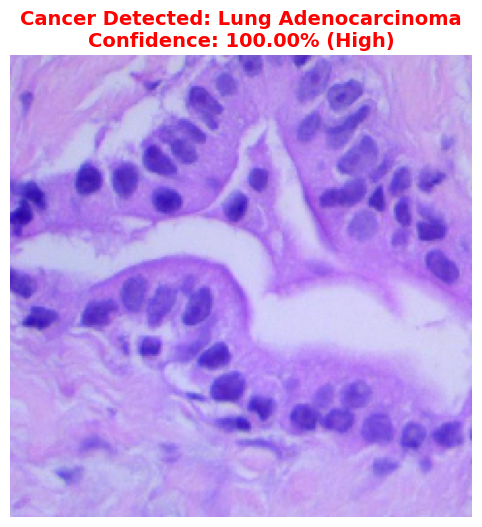


Detailed Prediction Probabilities:
Lung Adenocarcinoma: 100.00%
Normal Tissue: 0.00%
Squamous Cell Carcinoma: 0.00%


In [ ]:
# ==================================================
# TESTING THE MODEL: Example Predictions
# ==================================================

# Example 1: Adenocarcinoma sampledetect_and_display(image_path, model)

image_path = '/content/drive/MyDrive/Lung_Cancer_Dataset/test/lung_aca/lungaca100.jpeg'
print("\nTesting Image 1: Adenocarcinoma Sample")
detect_and_display(image_path, model)


Testing Image 2: Normal Tissue Sample
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


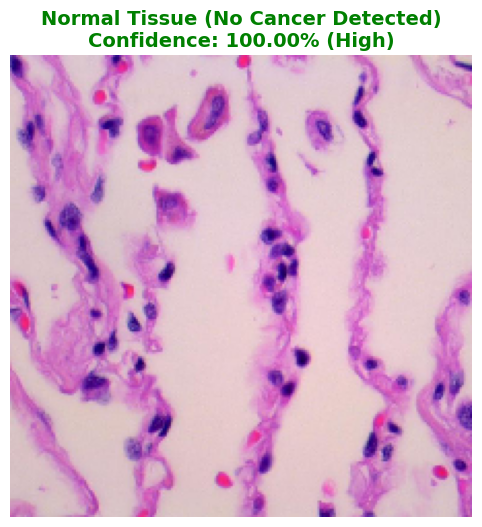


Detailed Prediction Probabilities:
Lung Adenocarcinoma: 0.00%
Normal Tissue: 100.00%
Squamous Cell Carcinoma: 0.00%


In [ ]:

# Example 2: Normal tissue sample
image_path = '/content/drive/MyDrive/Lung_Cancer_Dataset/test/lung_n/lungn1.jpeg'
print("\nTesting Image 2: Normal Tissue Sample")
detect_and_display(image_path, model)


Testing Image 3: Squamous Cell Carcinoma Sample
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


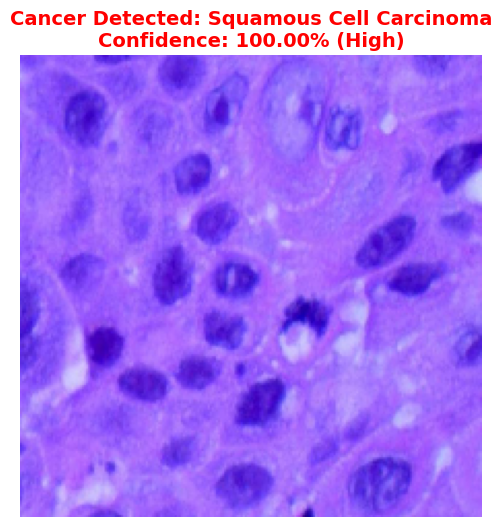


Detailed Prediction Probabilities:
Lung Adenocarcinoma: 0.00%
Normal Tissue: 0.00%
Squamous Cell Carcinoma: 100.00%


In [ ]:
# Example 3: Squamous Cell Carcinoma sample
image_path = '/content/drive/MyDrive/Lung_Cancer_Dataset/test/lung_scc/lungscc1018.jpeg'
print("\nTesting Image 3: Squamous Cell Carcinoma Sample")
detect_and_display(image_path, model)

In [2]:
# 1. Initialize a new Git repository
!git init

# Configure Git user identity
!git config --global user.email "hvsssen7@gmail.com" L
!git config --global user.name "hvsssen"

# 2. Add all files to the staging area
!git add .

# 3. Commit the changes
!git commit -m "Initial commit from Colab: Lung Cancer Detection Project"

# 4. Add the remote GitHub repository URL
# Replace 'your_username' with your actual GitHub username if needed for authentication
github_repo_url = "https://github.com/hvsssen/cnn_vgg16_lung_cancer_detection.git"
!git remote add origin {github_repo_url}

# 5. Push the changes to the 'main' branch
# You will be prompted for your GitHub username and Personal Access Token (PAT)
!git branch -M main
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
[main (root-commit) bc105b9] Initial commit from Colab: Lung Cancer Detection Project
 21 files changed, 51025 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.12.09/14.40.47.605300.log
 create mode 100644 .config/logs/2025.12.09/14.41.18.717681.log
 create mode 100644 .config/logs/2025.12.09/14.41.27.893750.log
 create mode 100644 .config/logs/2025.12.09/14.41.33.792924.log
 create mode 100644 .config/logs/2025.12.09/14.41.42.675750.log
 create mode 100644 .config

In [3]:
# Undo the last commit (keeps changes staged)
!git reset --soft HEAD~1

# Unstage all changes (moves changes to working directory)
!git restore --staged .

fatal: ambiguous argument 'HEAD~1': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'


The last commit has been undone, and the changes are now in your working directory. You can now make any necessary adjustments and commit again.

Let's first check the current Git status and log to understand the state of the repository.

In [4]:
# Check if any commits exist
!git log

# Check the status of your working directory and staging area
!git status

commit bc105b9361d10789f60231c99919cf6bd83acfaa (HEAD -> main)
Author: hvsssen <hvsssen7@gmail.com>
Date:   Sun Dec 28 19:14:53 2025 +0000

    Initial commit from Colab: Lung Cancer Detection Project
On branch main
nothing to commit, working tree clean


After running the above commands:

*   If `git log` shows **no commits** (e.g., `fatal: your current branch 'main' does not have any commits yet`), then the previous commit did not successfully register. In this case, your changes are likely still in your working directory or staging area. You can then proceed to re-add and re-commit the changes with the correct user details.

*   If `git log` **does show commits** (specifically the `Initial commit from Colab` commit), then the Git repository might be in an unusual state. In this scenario, please share the full output of both `git log` and `git status`.

Since your repository currently has only one commit, `HEAD~1` is not a valid reference. To effectively 'undo' this initial commit and start fresh with your Git repository, we will:

1.  **Remove the existing Git repository**: This deletes all Git history.
2.  **Re-initialize Git**: Creates a brand new empty Git repository.
3.  **Reconfigure user identity**: Set your email and name again.
4.  **Re-add and Re-commit**: Stage all your files and make a new initial commit.
5.  **Re-add remote and Push**: Link to your GitHub repository and push your changes.

In [5]:
# 1. Remove the existing Git repository
# This will delete the .git folder and all its history.
!rm -rf .git
print("Existing Git repository removed.")

# 2. Initialize a new Git repository
!git init
print("New Git repository initialized.")

# 3. Configure Git user identity (re-run this with your details)
!git config --global user.email "hvsssen7@gmail.com"
!git config --global user.name "hvsssen"
print("Git user identity configured.")

# 4. Add all files to the staging area
!git add .
print("All files added to staging.")

# 5. Commit the changes
!git commit -m "Initial commit from Colab: Lung Cancer Detection Project (Re-attempt)"
print("New initial commit created.")

# 6. Add the remote GitHub repository URL
github_repo_url = "https://github.com/hvsssen/cnn_vgg16_lung_cancer_detection.git"
# Remove existing remote 'origin' if it exists to avoid conflicts
!git remote remove origin || true # '|| true' prevents error if origin doesn't exist
!git remote add origin {github_repo_url}
print(f"Remote 'origin' added: {github_repo_url}")

# 7. Push the changes to the 'main' branch
# You will be prompted for your GitHub username and Personal Access Token (PAT)
!git branch -M main
!git push -u origin main
print("Attempting to push to GitHub. You may be prompted for credentials.")

Existing Git repository removed.
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
New Git repository initialized.
Git user identity configured.
All files added to staging.
[master (root-commit) 4224c7f] Initial commit from Colab: Lung Cancer Detection Project (Re-attempt)
 21 files changed, 51025 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 